<h1>360 Equirectangular image analysis to identify roll</h1>

In [1]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
import numpy as np


In [3]:
TEST_PATH = "/Users/saad/Desktop/Test Images"
TRAIN_PATH = "/Users/saad/Desktop/Training Images"
MODEL_PATH = "/Users/saad/Desktop/Model"
BATCH_SIZE = 8
IMG_HEIGHT = 128
IMG_WIDTH = 256
SEED = 123

<h4> Loading the data: </h4>

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=SEED,
    validation_split=0.1,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=SEED,
    validation_split=0.1,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)



Found 138 files belonging to 8 classes.
Using 125 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 138 files belonging to 8 classes.
Using 13 files for validation.


2022-06-25 23:13:06.592616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 23:13:06.592960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<h4>Displaying the loaded Images:</h4>

2022-06-25 23:13:13.899668: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


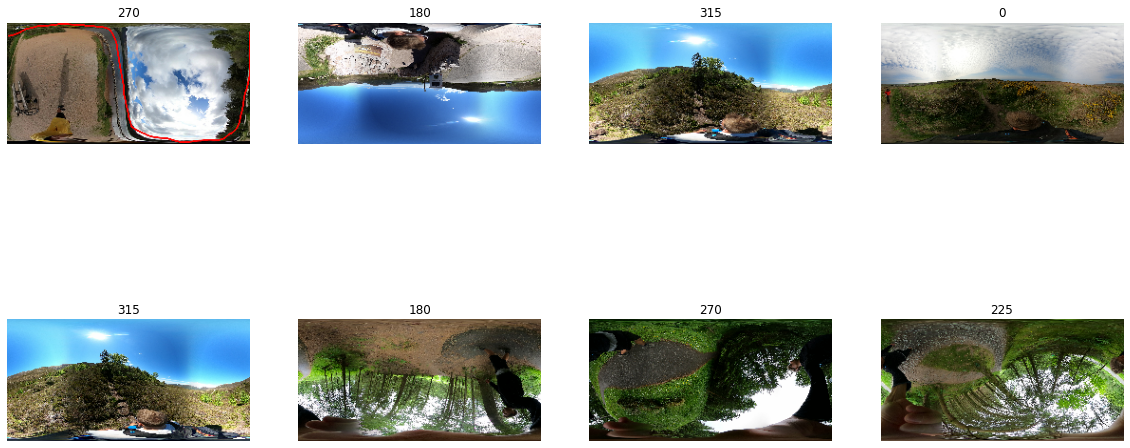

In [5]:
class_names = train_ds.class_names

### To visualize the images
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Plotting the images
plt.show()

<h4> Using a pre-trained VGG16 model </h4>

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (128, 256, 3), # Shape of our images

include_top = False, # Leave out the last fully connected layer

weights = 'imagenet')

Since we don’t have to train all the layers, we make them non_trainable:

In [7]:
for layer in base_model.layers:
  layer.trainable = False

Defining the model Architecture and compliling the model

In [8]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Add a dropout rate of 0.8
x = layers.Dropout(0.8)(x)

# Add a final sigmoid layer with 8 node for classification output, 
# we are using 8 nodes since we have 8 output classes
x = layers.Dense(8, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

# At first we are using RMSprop as an optimizer and afterwards we will try with ADAM optimizer for better performance.
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])


/Users/saad/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [61]:
vgghist = model.fit(train_ds, validation_data = validation_ds, epochs = 30)



Epoch 1/30


2022-06-25 19:56:38.238857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 25.2466 - acc: 0.1920

2022-06-25 19:56:42.681280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 5s 196ms/step - loss: 25.2466 - acc: 0.1920 - val_loss: 4.1175 - val_acc: 0.5385
Epoch 2/30
16/16 [==============================] - 4s 163ms/step - loss: 14.3000 - acc: 0.3920 - val_loss: 2.4528 - val_acc: 0.6154
Epoch 3/30
16/16 [==============================] - 4s 165ms/step - loss: 9.2376 - acc: 0.5680 - val_loss: 1.3484 - val_acc: 0.8462
Epoch 4/30
16/16 [==============================] - 4s 168ms/step - loss: 6.9704 - acc: 0.5920 - val_loss: 0.6398 - val_acc: 0.7692
Epoch 5/30
16/16 [==============================] - 4s 163ms/step - loss: 7.0418 - acc: 0.5840 - val_loss: 0.4595 - val_acc: 0.8462
Epoch 6/30
16/16 [==============================] - 4s 165ms/step - loss: 6.2024 - acc: 0.6560 - val_loss: 0.8376 - val_acc: 0.8462
Epoch 7/30
16/16 [==============================] - 4s 180ms/step - loss: 3.6951 - acc: 0.7040 - val_loss: 1.4121 - val_acc: 0.7692
Epoch 8/30
16/16 [==============================] - 4s 169ms/step - loss: 3.6577 - ac

Saving the model, so that we can resuse the model.

In [62]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: /Users/saad/Desktop/Model/assets


For using the model from directory, to skip the training.

In [9]:
# Check its architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 64, 128)       0     

In [81]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

class_names = test_ds.class_names

Found 8 files belonging to 8 classes.


Evaluating the Model Performance on Test data and displaying the missclassified Images:

prediction:  225   actual 270


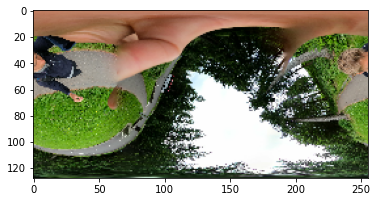

prediction:  180   actual 135


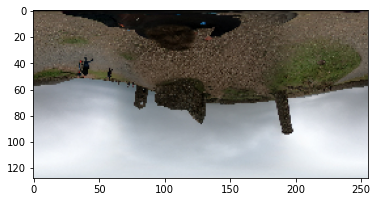

Total Number of Missclassified Images:  2
Accurancy on data:  75.0 %


In [88]:
miss_count = 0
total_count = 0
for images, labels in test_ds:
  for i in range(8):
    total_count += 1
    image = images[i]
    predictions = model.predict(image[np.newaxis, ...])
    if( np.argmax(predictions) != np.argmax(labels[i])):
      print("prediction: ", class_names[np.argmax(predictions)], "  actual", class_names[np.argmax(labels[i])])
      plt.imshow(image.numpy().astype("uint8"))
      miss_count= miss_count +1
      plt.show()
print("Total Number of Missclassified Images: ",  miss_count)
print("Accurancy on data: ", ((total_count-miss_count)/total_count)*100, "%" )

<h1>Analysis</h1>

The model has performed quite well on the unseen data. It has misclassified the above two images:

1. In first case, the image was imprecisely labelled, infact the angle lies between the 225 and 270, and model has predicted its value to be 225.

2. In second case, it can be observed that the angle is in between 135 and 180. Because the horizon is not perfectly straight.  

The above analysis reveal that the accuracy of the model is +- (class width/2) which is equal to +- 22.5 degrees. It can be further improved by: 

1.  Using more precise labelling technique, such as using a gyroscope with the camera. The gyroscope can be configured by using arduino. 
    As the images will be taken by the camera the gyroscope with the help of arduino can record the image label, which can later be used for training the model. 
2.  Updating the model by adding a regression network at the end and using L2 loss function (Mean Squared Loss).



Following code block is used for manual predction on the images

Predicted value 180


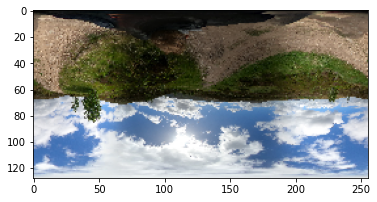

In [84]:
IMAGE_PATH = '/Users/saad/Desktop/GSAA2766.JPG'

image = tf.keras.utils.load_img( IMAGE_PATH, color_mode="rgb", target_size=(128,256), interpolation='nearest' )
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr =  np.array([input_arr]) 
predictions = model.predict(input_arr)
print("Predicted value", class_names[np.argmax(predictions)])


plt.imshow(np.squeeze(image))
plt.show()
